<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:09:54] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


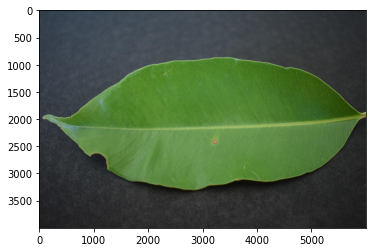

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

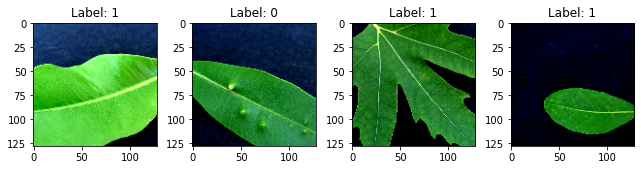

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:10:02] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:10:04] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.251334779692732 samples/sec                   batch loss = 1.2044342756271362 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2659500713365792 samples/sec                   batch loss = 0.9066967964172363 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2615573087946037 samples/sec                   batch loss = 0.45955339074134827 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.2600885588180841 samples/sec                   batch loss = 1.4778066873550415 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2639163862687277 samples/sec                   batch loss = 0.7130848169326782 | accuracy = 0.46


Epoch[1] Batch[30] Speed: 1.261982245672142 samples/sec                   batch loss = 1.163674235343933 | accuracy = 0.49166666666666664


Epoch[1] Batch[35] Speed: 1.2614278349186128 samples/sec                   batch loss = 0.8123052716255188 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.2617597776287013 samples/sec                   batch loss = 0.3797434866428375 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2622741166339209 samples/sec                   batch loss = 1.001837134361267 | accuracy = 0.5611111111111111


Epoch[1] Batch[50] Speed: 1.2662752235690056 samples/sec                   batch loss = 1.1684564352035522 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2663312319665982 samples/sec                   batch loss = 0.7144327163696289 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2543585351206896 samples/sec                   batch loss = 0.5535191893577576 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2610355917583438 samples/sec                   batch loss = 1.586483359336853 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2575166326301315 samples/sec                   batch loss = 0.7939027547836304 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2695080014219637 samples/sec                   batch loss = 0.457335889339447 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.261810737143847 samples/sec                   batch loss = 0.37948697805404663 | accuracy = 0.596875


Epoch[1] Batch[85] Speed: 1.2610577715922076 samples/sec                   batch loss = 0.45553261041641235 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2685000567441758 samples/sec                   batch loss = 0.49725356698036194 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2704501062645097 samples/sec                   batch loss = 0.9933609962463379 | accuracy = 0.6105263157894737


Epoch[1] Batch[100] Speed: 1.2670405585207816 samples/sec                   batch loss = 0.8354729413986206 | accuracy = 0.6125


Epoch[1] Batch[105] Speed: 1.2710142111301896 samples/sec                   batch loss = 0.6488021612167358 | accuracy = 0.6095238095238096


Epoch[1] Batch[110] Speed: 1.2720598164457315 samples/sec                   batch loss = 0.24769653379917145 | accuracy = 0.6113636363636363


Epoch[1] Batch[115] Speed: 1.2608668989010752 samples/sec                   batch loss = 0.5162148475646973 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2610956876449693 samples/sec                   batch loss = 1.5047436952590942 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2616741900895967 samples/sec                   batch loss = 0.6845747232437134 | accuracy = 0.622


Epoch[1] Batch[130] Speed: 1.2670542421679014 samples/sec                   batch loss = 0.29395779967308044 | accuracy = 0.6230769230769231


Epoch[1] Batch[135] Speed: 1.2668332348064841 samples/sec                   batch loss = 0.7753680348396301 | accuracy = 0.6240740740740741


Epoch[1] Batch[140] Speed: 1.2668651852153896 samples/sec                   batch loss = 0.372412770986557 | accuracy = 0.6232142857142857


Epoch[1] Batch[145] Speed: 1.2668060686606544 samples/sec                   batch loss = 0.3052849769592285 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2694222239776145 samples/sec                   batch loss = 0.48376601934432983 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.2658074698202324 samples/sec                   batch loss = 0.7946758270263672 | accuracy = 0.632258064516129


Epoch[1] Batch[160] Speed: 1.2652802283976 samples/sec                   batch loss = 0.39907750487327576 | accuracy = 0.6328125


Epoch[1] Batch[165] Speed: 1.2693439489684453 samples/sec                   batch loss = 0.3611244261264801 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.2695240439552191 samples/sec                   batch loss = 0.48083817958831787 | accuracy = 0.6397058823529411


Epoch[1] Batch[175] Speed: 1.273000884343702 samples/sec                   batch loss = 0.7431250810623169 | accuracy = 0.6371428571428571


Epoch[1] Batch[180] Speed: 1.269209127294355 samples/sec                   batch loss = 0.7797269225120544 | accuracy = 0.6388888888888888


Epoch[1] Batch[185] Speed: 1.2682557267128167 samples/sec                   batch loss = 0.6783024072647095 | accuracy = 0.6418918918918919


Epoch[1] Batch[190] Speed: 1.267912021324408 samples/sec                   batch loss = 0.48030632734298706 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.2635816901786088 samples/sec                   batch loss = 0.30347830057144165 | accuracy = 0.6487179487179487


Epoch[1] Batch[200] Speed: 1.268673100869518 samples/sec                   batch loss = 0.460560142993927 | accuracy = 0.65


Epoch[1] Batch[205] Speed: 1.2702410883063233 samples/sec                   batch loss = 0.28648099303245544 | accuracy = 0.65


Epoch[1] Batch[210] Speed: 1.2694459484940117 samples/sec                   batch loss = 0.800451934337616 | accuracy = 0.6476190476190476


Epoch[1] Batch[215] Speed: 1.2663640173377246 samples/sec                   batch loss = 0.4575924277305603 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.272759452167445 samples/sec                   batch loss = 0.49432438611984253 | accuracy = 0.6579545454545455


Epoch[1] Batch[225] Speed: 1.2613586033856783 samples/sec                   batch loss = 0.6848834156990051 | accuracy = 0.66


Epoch[1] Batch[230] Speed: 1.265944626482478 samples/sec                   batch loss = 0.24283672869205475 | accuracy = 0.6652173913043479


Epoch[1] Batch[235] Speed: 1.2695734229194515 samples/sec                   batch loss = 0.30018484592437744 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.270927267262026 samples/sec                   batch loss = 0.42967161536216736 | accuracy = 0.665625


Epoch[1] Batch[245] Speed: 1.2631598602071896 samples/sec                   batch loss = 0.16387513279914856 | accuracy = 0.6673469387755102


Epoch[1] Batch[250] Speed: 1.264313186924983 samples/sec                   batch loss = 0.5179422497749329 | accuracy = 0.665


Epoch[1] Batch[255] Speed: 1.2585120059314407 samples/sec                   batch loss = 0.5451453924179077 | accuracy = 0.6637254901960784


Epoch[1] Batch[260] Speed: 1.2651371099292492 samples/sec                   batch loss = 0.36595720052719116 | accuracy = 0.6663461538461538


Epoch[1] Batch[265] Speed: 1.2629030377406454 samples/sec                   batch loss = 0.5394753217697144 | accuracy = 0.6688679245283019


Epoch[1] Batch[270] Speed: 1.264905994274408 samples/sec                   batch loss = 0.5665324330329895 | accuracy = 0.6703703703703704


Epoch[1] Batch[275] Speed: 1.2666608834530708 samples/sec                   batch loss = 0.46616750955581665 | accuracy = 0.6718181818181819


Epoch[1] Batch[280] Speed: 1.2695515189359907 samples/sec                   batch loss = 0.2652253210544586 | accuracy = 0.6723214285714286


Epoch[1] Batch[285] Speed: 1.2633119490964955 samples/sec                   batch loss = 0.5554831624031067 | accuracy = 0.6728070175438596


Epoch[1] Batch[290] Speed: 1.2650301738649503 samples/sec                   batch loss = 0.5623507499694824 | accuracy = 0.6715517241379311


Epoch[1] Batch[295] Speed: 1.2572293126917677 samples/sec                   batch loss = 0.5464158654212952 | accuracy = 0.6728813559322034


Epoch[1] Batch[300] Speed: 1.2623658645375544 samples/sec                   batch loss = 0.4899336099624634 | accuracy = 0.6733333333333333


Epoch[1] Batch[305] Speed: 1.271954889207461 samples/sec                   batch loss = 0.6664996147155762 | accuracy = 0.6737704918032786


Epoch[1] Batch[310] Speed: 1.2656149657627536 samples/sec                   batch loss = 1.004608392715454 | accuracy = 0.6741935483870968


Epoch[1] Batch[315] Speed: 1.2644018010239888 samples/sec                   batch loss = 1.2884330749511719 | accuracy = 0.6738095238095239


Epoch[1] Batch[320] Speed: 1.2624018645112682 samples/sec                   batch loss = 0.8990941643714905 | accuracy = 0.67265625


Epoch[1] Batch[325] Speed: 1.2652224046382092 samples/sec                   batch loss = 0.49029844999313354 | accuracy = 0.6738461538461539


Epoch[1] Batch[330] Speed: 1.2623294867026733 samples/sec                   batch loss = 0.42819181084632874 | accuracy = 0.6727272727272727


Epoch[1] Batch[335] Speed: 1.2598397004718425 samples/sec                   batch loss = 0.6746994853019714 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2602988876354755 samples/sec                   batch loss = 0.5907902121543884 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2624552508379827 samples/sec                   batch loss = 0.47810065746307373 | accuracy = 0.6739130434782609


Epoch[1] Batch[350] Speed: 1.2598256045951166 samples/sec                   batch loss = 0.6808889508247375 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2656032226186795 samples/sec                   batch loss = 0.8712863922119141 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2668058773538995 samples/sec                   batch loss = 0.4330878257751465 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.2683865102023397 samples/sec                   batch loss = 0.3884676694869995 | accuracy = 0.6726027397260274


Epoch[1] Batch[370] Speed: 1.2686083476787495 samples/sec                   batch loss = 0.47950655221939087 | accuracy = 0.672972972972973


Epoch[1] Batch[375] Speed: 1.264329384273413 samples/sec                   batch loss = 0.5873463749885559 | accuracy = 0.6733333333333333


Epoch[1] Batch[380] Speed: 1.261614987766019 samples/sec                   batch loss = 0.7377616763114929 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2600721860277315 samples/sec                   batch loss = 0.49864402413368225 | accuracy = 0.675974025974026


Epoch[1] Batch[390] Speed: 1.2641787649485876 samples/sec                   batch loss = 0.24987757205963135 | accuracy = 0.676923076923077


Epoch[1] Batch[395] Speed: 1.2668992419166458 samples/sec                   batch loss = 0.8621288537979126 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2673233820608631 samples/sec                   batch loss = 0.8978666067123413 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2650245461518022 samples/sec                   batch loss = 0.40746667981147766 | accuracy = 0.6753086419753086


Epoch[1] Batch[410] Speed: 1.2661354153522735 samples/sec                   batch loss = 0.4574384093284607 | accuracy = 0.676829268292683


Epoch[1] Batch[415] Speed: 1.26804915526203 samples/sec                   batch loss = 0.5158108472824097 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2666989459210245 samples/sec                   batch loss = 0.8884868025779724 | accuracy = 0.6773809523809524


Epoch[1] Batch[425] Speed: 1.2637514910674552 samples/sec                   batch loss = 0.6242448091506958 | accuracy = 0.678235294117647


Epoch[1] Batch[430] Speed: 1.2697949069596004 samples/sec                   batch loss = 0.46225666999816895 | accuracy = 0.6779069767441861


Epoch[1] Batch[435] Speed: 1.2707498539493438 samples/sec                   batch loss = 0.529745876789093 | accuracy = 0.6758620689655173


Epoch[1] Batch[440] Speed: 1.2670389318131579 samples/sec                   batch loss = 1.4196674823760986 | accuracy = 0.6744318181818182


Epoch[1] Batch[445] Speed: 1.2681213277997385 samples/sec                   batch loss = 0.46160465478897095 | accuracy = 0.6747191011235955


Epoch[1] Batch[450] Speed: 1.2668861356098178 samples/sec                   batch loss = 0.4768426716327667 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.262588926446732 samples/sec                   batch loss = 0.3297872245311737 | accuracy = 0.6752747252747253


Epoch[1] Batch[460] Speed: 1.260859223501987 samples/sec                   batch loss = 0.2620355486869812 | accuracy = 0.6760869565217391


Epoch[1] Batch[465] Speed: 1.2689103938586042 samples/sec                   batch loss = 0.7094111442565918 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.2639873272907527 samples/sec                   batch loss = 0.7462883591651917 | accuracy = 0.6776595744680851


Epoch[1] Batch[475] Speed: 1.26168861200999 samples/sec                   batch loss = 1.0503277778625488 | accuracy = 0.6773684210526316


Epoch[1] Batch[480] Speed: 1.266930334605156 samples/sec                   batch loss = 0.8444423079490662 | accuracy = 0.6770833333333334


Epoch[1] Batch[485] Speed: 1.2652482624647823 samples/sec                   batch loss = 0.4876056909561157 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2649749481334527 samples/sec                   batch loss = 0.40911513566970825 | accuracy = 0.6795918367346939


Epoch[1] Batch[495] Speed: 1.2669321523787804 samples/sec                   batch loss = 0.2306678295135498 | accuracy = 0.6803030303030303


Epoch[1] Batch[500] Speed: 1.266508369627562 samples/sec                   batch loss = 0.7889138460159302 | accuracy = 0.679


Epoch[1] Batch[505] Speed: 1.2598172796617182 samples/sec                   batch loss = 0.7309845685958862 | accuracy = 0.6787128712871288


Epoch[1] Batch[510] Speed: 1.2589932776012542 samples/sec                   batch loss = 0.13616032898426056 | accuracy = 0.6779411764705883


Epoch[1] Batch[515] Speed: 1.2661593038379446 samples/sec                   batch loss = 0.4346475303173065 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.2634226859958737 samples/sec                   batch loss = 0.37655261158943176 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.2635751236840878 samples/sec                   batch loss = 0.9240502715110779 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.2727635074716712 samples/sec                   batch loss = 0.5631392598152161 | accuracy = 0.6797169811320755


Epoch[1] Batch[535] Speed: 1.2650012727511815 samples/sec                   batch loss = 0.6793572902679443 | accuracy = 0.6799065420560748


Epoch[1] Batch[540] Speed: 1.2630677115882203 samples/sec                   batch loss = 0.44618549942970276 | accuracy = 0.6819444444444445


Epoch[1] Batch[545] Speed: 1.2648694698955594 samples/sec                   batch loss = 0.3213689923286438 | accuracy = 0.681651376146789


Epoch[1] Batch[550] Speed: 1.265781302635684 samples/sec                   batch loss = 0.6703959703445435 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.2660876410850375 samples/sec                   batch loss = 0.3727882504463196 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.2638705883088541 samples/sec                   batch loss = 0.7119264006614685 | accuracy = 0.6821428571428572


Epoch[1] Batch[565] Speed: 1.2644781334471904 samples/sec                   batch loss = 0.33206304907798767 | accuracy = 0.6836283185840708


Epoch[1] Batch[570] Speed: 1.2629174877682554 samples/sec                   batch loss = 0.22792808711528778 | accuracy = 0.6846491228070175


Epoch[1] Batch[575] Speed: 1.2624674106326876 samples/sec                   batch loss = 0.3449537754058838 | accuracy = 0.6847826086956522


Epoch[1] Batch[580] Speed: 1.2699707078597056 samples/sec                   batch loss = 0.37958648800849915 | accuracy = 0.6853448275862069


Epoch[1] Batch[585] Speed: 1.2602310105830399 samples/sec                   batch loss = 0.7060362696647644 | accuracy = 0.6846153846153846


Epoch[1] Batch[590] Speed: 1.268753499954815 samples/sec                   batch loss = 0.7833144068717957 | accuracy = 0.684322033898305


Epoch[1] Batch[595] Speed: 1.2687687558240326 samples/sec                   batch loss = 0.5324755311012268 | accuracy = 0.684453781512605


Epoch[1] Batch[600] Speed: 1.2662444497326595 samples/sec                   batch loss = 0.754966676235199 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.2666655694123343 samples/sec                   batch loss = 0.5792415142059326 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2645445625434617 samples/sec                   batch loss = 0.7201001048088074 | accuracy = 0.6811475409836065


Epoch[1] Batch[615] Speed: 1.2649319345398424 samples/sec                   batch loss = 0.4149618148803711 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2663614365035136 samples/sec                   batch loss = 0.580842912197113 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.2681182605393542 samples/sec                   batch loss = 0.39069196581840515 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.2637320720630603 samples/sec                   batch loss = 0.4868837594985962 | accuracy = 0.6813492063492064


Epoch[1] Batch[635] Speed: 1.2673120858410272 samples/sec                   batch loss = 0.47263890504837036 | accuracy = 0.6807086614173228


Epoch[1] Batch[640] Speed: 1.2682238978624614 samples/sec                   batch loss = 0.1351911723613739 | accuracy = 0.68203125


Epoch[1] Batch[645] Speed: 1.2638987712759895 samples/sec                   batch loss = 1.104866862297058 | accuracy = 0.6825581395348838


Epoch[1] Batch[650] Speed: 1.2650645135385497 samples/sec                   batch loss = 0.4643160104751587 | accuracy = 0.683076923076923


Epoch[1] Batch[655] Speed: 1.2664037826315375 samples/sec                   batch loss = 0.766123354434967 | accuracy = 0.683587786259542


Epoch[1] Batch[660] Speed: 1.269845460351465 samples/sec                   batch loss = 0.6758236885070801 | accuracy = 0.6837121212121212


Epoch[1] Batch[665] Speed: 1.2671556826144053 samples/sec                   batch loss = 0.3503192365169525 | accuracy = 0.6838345864661655


Epoch[1] Batch[670] Speed: 1.2664100917778833 samples/sec                   batch loss = 0.43693748116493225 | accuracy = 0.683955223880597


Epoch[1] Batch[675] Speed: 1.2604460270166369 samples/sec                   batch loss = 0.4053879380226135 | accuracy = 0.6848148148148148


Epoch[1] Batch[680] Speed: 1.2677455072008634 samples/sec                   batch loss = 1.0585064888000488 | accuracy = 0.6856617647058824


Epoch[1] Batch[685] Speed: 1.2762427993090106 samples/sec                   batch loss = 0.3156315088272095 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.2676560406920132 samples/sec                   batch loss = 0.4069501757621765 | accuracy = 0.6873188405797102


Epoch[1] Batch[695] Speed: 1.2624856507639568 samples/sec                   batch loss = 0.1937141716480255 | accuracy = 0.6877697841726619


Epoch[1] Batch[700] Speed: 1.2635792158393269 samples/sec                   batch loss = 0.7210713624954224 | accuracy = 0.6882142857142857


Epoch[1] Batch[705] Speed: 1.2639064837258973 samples/sec                   batch loss = 0.6482483744621277 | accuracy = 0.6875886524822695


Epoch[1] Batch[710] Speed: 1.268781901112516 samples/sec                   batch loss = 0.4155963957309723 | accuracy = 0.6880281690140845


Epoch[1] Batch[715] Speed: 1.2673097883294335 samples/sec                   batch loss = 0.18847596645355225 | accuracy = 0.6895104895104895


Epoch[1] Batch[720] Speed: 1.2702813860024773 samples/sec                   batch loss = 0.47205889225006104 | accuracy = 0.6888888888888889


Epoch[1] Batch[725] Speed: 1.2669799904016759 samples/sec                   batch loss = 0.3919655382633209 | accuracy = 0.6893103448275862


Epoch[1] Batch[730] Speed: 1.2701439611704495 samples/sec                   batch loss = 0.508282482624054 | accuracy = 0.6893835616438356


Epoch[1] Batch[735] Speed: 1.266320718067138 samples/sec                   batch loss = 0.540216326713562 | accuracy = 0.6904761904761905


Epoch[1] Batch[740] Speed: 1.270306873932165 samples/sec                   batch loss = 0.5230890512466431 | accuracy = 0.6908783783783784


Epoch[1] Batch[745] Speed: 1.2761180588346972 samples/sec                   batch loss = 0.4862532615661621 | accuracy = 0.6916107382550336


Epoch[1] Batch[750] Speed: 1.2672736993446398 samples/sec                   batch loss = 0.3993026614189148 | accuracy = 0.6913333333333334


Epoch[1] Batch[755] Speed: 1.259488249119169 samples/sec                   batch loss = 0.7029657363891602 | accuracy = 0.6910596026490067


Epoch[1] Batch[760] Speed: 1.2558985562629994 samples/sec                   batch loss = 0.3526715338230133 | accuracy = 0.6904605263157895


Epoch[1] Batch[765] Speed: 1.257125969938464 samples/sec                   batch loss = 0.5905393958091736 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.2519210812602506 samples/sec                   batch loss = 0.8905822038650513 | accuracy = 0.6905844155844156


Epoch[1] Batch[775] Speed: 1.2580451578182597 samples/sec                   batch loss = 0.37413448095321655 | accuracy = 0.6912903225806452


Epoch[1] Batch[780] Speed: 1.2578480286932907 samples/sec                   batch loss = 0.7560068964958191 | accuracy = 0.6919871794871795


Epoch[1] Batch[785] Speed: 1.2594634771179145 samples/sec                   batch loss = 0.33462169766426086 | accuracy = 0.6926751592356688


[Epoch 1] training: accuracy=0.692258883248731
[Epoch 1] time cost: 650.9757533073425
[Epoch 1] validation: validation accuracy=0.7577777777777778


Epoch[2] Batch[5] Speed: 1.2657121653538823 samples/sec                   batch loss = 0.4643668234348297 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.262627314724226 samples/sec                   batch loss = 0.9382336735725403 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2590815254735397 samples/sec                   batch loss = 0.5844685435295105 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2617571206346714 samples/sec                   batch loss = 0.23914919793605804 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2585200304045283 samples/sec                   batch loss = 0.44181981682777405 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.259999601960308 samples/sec                   batch loss = 1.4024628400802612 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2511486115277948 samples/sec                   batch loss = 0.4518662989139557 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2536137789486756 samples/sec                   batch loss = 0.6333889365196228 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2518833412266805 samples/sec                   batch loss = 0.2824786901473999 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2523765698640885 samples/sec                   batch loss = 0.4775635302066803 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.263329928252338 samples/sec                   batch loss = 0.34812605381011963 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2634356255944046 samples/sec                   batch loss = 0.9026205539703369 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2567910000030713 samples/sec                   batch loss = 0.2906571626663208 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2563377518381107 samples/sec                   batch loss = 0.45360541343688965 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2655270406841679 samples/sec                   batch loss = 0.49684712290763855 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2662282988456541 samples/sec                   batch loss = 0.6785749793052673 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.258581869482757 samples/sec                   batch loss = 0.523710310459137 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2621532311180674 samples/sec                   batch loss = 0.2737942636013031 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2593962572459205 samples/sec                   batch loss = 0.5963293313980103 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2572603094092998 samples/sec                   batch loss = 0.7491081357002258 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.2570447772511166 samples/sec                   batch loss = 0.19257892668247223 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2580171409658405 samples/sec                   batch loss = 0.6364590525627136 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2600010213860209 samples/sec                   batch loss = 0.2264508754014969 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2631136415721584 samples/sec                   batch loss = 0.610420286655426 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.25776202807074 samples/sec                   batch loss = 1.4755711555480957 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.2572940400967991 samples/sec                   batch loss = 0.8851983547210693 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2525772245315625 samples/sec                   batch loss = 0.27677738666534424 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.259800535526601 samples/sec                   batch loss = 0.3913881182670593 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2528904902527167 samples/sec                   batch loss = 0.35041001439094543 | accuracy = 0.7310344827586207


Epoch[2] Batch[150] Speed: 1.2634935716064108 samples/sec                   batch loss = 0.52534019947052 | accuracy = 0.7383333333333333


Epoch[2] Batch[155] Speed: 1.2581414811637415 samples/sec                   batch loss = 0.9788168668746948 | accuracy = 0.7338709677419355


Epoch[2] Batch[160] Speed: 1.2620748056116131 samples/sec                   batch loss = 0.36940619349479675 | accuracy = 0.7375


Epoch[2] Batch[165] Speed: 1.25901897591903 samples/sec                   batch loss = 0.8627849817276001 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.2576000544500756 samples/sec                   batch loss = 0.17630386352539062 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.256689894319411 samples/sec                   batch loss = 0.7312450408935547 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2569451374523024 samples/sec                   batch loss = 0.8021973371505737 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2528314544837191 samples/sec                   batch loss = 0.12813501060009003 | accuracy = 0.7351351351351352


Epoch[2] Batch[190] Speed: 1.2579670533395306 samples/sec                   batch loss = 0.4056074023246765 | accuracy = 0.7381578947368421


Epoch[2] Batch[195] Speed: 1.2573699878783808 samples/sec                   batch loss = 0.6205220818519592 | accuracy = 0.7371794871794872


Epoch[2] Batch[200] Speed: 1.25879292338944 samples/sec                   batch loss = 0.5603655576705933 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2686141991768973 samples/sec                   batch loss = 1.6141746044158936 | accuracy = 0.7341463414634146


Epoch[2] Batch[210] Speed: 1.2610237438761989 samples/sec                   batch loss = 0.6579983830451965 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2658910401541172 samples/sec                   batch loss = 0.3874899446964264 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.261241306477917 samples/sec                   batch loss = 0.44476625323295593 | accuracy = 0.740909090909091


Epoch[2] Batch[225] Speed: 1.2627478158665377 samples/sec                   batch loss = 0.4971347153186798 | accuracy = 0.7422222222222222


Epoch[2] Batch[230] Speed: 1.262322268373768 samples/sec                   batch loss = 0.6439552307128906 | accuracy = 0.7445652173913043


Epoch[2] Batch[235] Speed: 1.26225977629316 samples/sec                   batch loss = 0.7107383608818054 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.260454928441536 samples/sec                   batch loss = 0.4520098567008972 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2608160155916226 samples/sec                   batch loss = 0.5141925811767578 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2579024452492957 samples/sec                   batch loss = 0.7370072603225708 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2629114985719505 samples/sec                   batch loss = 0.6911469101905823 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2595319334193131 samples/sec                   batch loss = 0.6289041638374329 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2576475674161856 samples/sec                   batch loss = 0.2696365416049957 | accuracy = 0.7509433962264151


Epoch[2] Batch[270] Speed: 1.259933933360664 samples/sec                   batch loss = 0.5179223418235779 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2643580641259504 samples/sec                   batch loss = 0.5095762014389038 | accuracy = 0.7518181818181818


Epoch[2] Batch[280] Speed: 1.268579858368818 samples/sec                   batch loss = 0.4520401656627655 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.2613248439152216 samples/sec                   batch loss = 0.5772649049758911 | accuracy = 0.7517543859649123


Epoch[2] Batch[290] Speed: 1.2651925406408744 samples/sec                   batch loss = 1.092421531677246 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2580944969254058 samples/sec                   batch loss = 0.4035896360874176 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.2662219915105275 samples/sec                   batch loss = 0.38414257764816284 | accuracy = 0.7466666666666667


Epoch[2] Batch[305] Speed: 1.2626255092826277 samples/sec                   batch loss = 0.3787201941013336 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.259078785257148 samples/sec                   batch loss = 0.4109628200531006 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.2632206343007157 samples/sec                   batch loss = 0.47919678688049316 | accuracy = 0.7476190476190476


Epoch[2] Batch[320] Speed: 1.2650980919109793 samples/sec                   batch loss = 0.773332953453064 | accuracy = 0.7484375


Epoch[2] Batch[325] Speed: 1.2576849958320089 samples/sec                   batch loss = 0.1682012677192688 | accuracy = 0.7484615384615385


Epoch[2] Batch[330] Speed: 1.260837145405861 samples/sec                   batch loss = 0.3106707036495209 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2593719615330887 samples/sec                   batch loss = 0.5872806310653687 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.264922969768979 samples/sec                   batch loss = 0.8359766602516174 | accuracy = 0.7485294117647059


Epoch[2] Batch[345] Speed: 1.2622584467416478 samples/sec                   batch loss = 0.97978675365448 | accuracy = 0.75


Epoch[2] Batch[350] Speed: 1.2636687740597305 samples/sec                   batch loss = 0.19991685450077057 | accuracy = 0.7507142857142857


Epoch[2] Batch[355] Speed: 1.25978729189317 samples/sec                   batch loss = 0.6772682070732117 | accuracy = 0.7507042253521127


Epoch[2] Batch[360] Speed: 1.2675661079686171 samples/sec                   batch loss = 0.5242810249328613 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2690768301641995 samples/sec                   batch loss = 0.5568327307701111 | accuracy = 0.7493150684931507


Epoch[2] Batch[370] Speed: 1.268719919145385 samples/sec                   batch loss = 0.8329331874847412 | accuracy = 0.75


Epoch[2] Batch[375] Speed: 1.2654605083273651 samples/sec                   batch loss = 0.2879844605922699 | accuracy = 0.75


Epoch[2] Batch[380] Speed: 1.264159523319212 samples/sec                   batch loss = 0.4000859260559082 | accuracy = 0.7493421052631579


Epoch[2] Batch[385] Speed: 1.2623533267702138 samples/sec                   batch loss = 0.6834324598312378 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.2600704825248492 samples/sec                   batch loss = 0.3460438847541809 | accuracy = 0.7519230769230769


Epoch[2] Batch[395] Speed: 1.2665322721886774 samples/sec                   batch loss = 0.3259891867637634 | accuracy = 0.7531645569620253


Epoch[2] Batch[400] Speed: 1.2722242822834984 samples/sec                   batch loss = 0.5670000910758972 | accuracy = 0.755625


Epoch[2] Batch[405] Speed: 1.2690599349843028 samples/sec                   batch loss = 0.27343958616256714 | accuracy = 0.7549382716049383


Epoch[2] Batch[410] Speed: 1.2663811275787267 samples/sec                   batch loss = 0.3218989074230194 | accuracy = 0.7548780487804878


Epoch[2] Batch[415] Speed: 1.267117592693364 samples/sec                   batch loss = 0.12775519490242004 | accuracy = 0.7566265060240964


Epoch[2] Batch[420] Speed: 1.267327307065744 samples/sec                   batch loss = 0.2595062851905823 | accuracy = 0.756547619047619


Epoch[2] Batch[425] Speed: 1.2565174685284886 samples/sec                   batch loss = 0.8299645185470581 | accuracy = 0.7564705882352941


Epoch[2] Batch[430] Speed: 1.2644471610033448 samples/sec                   batch loss = 0.3701908588409424 | accuracy = 0.7546511627906977


Epoch[2] Batch[435] Speed: 1.2620160403430727 samples/sec                   batch loss = 0.7238315939903259 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2619537684220914 samples/sec                   batch loss = 0.5888386368751526 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.2660967179183849 samples/sec                   batch loss = 0.431663453578949 | accuracy = 0.7522471910112359


Epoch[2] Batch[450] Speed: 1.2619703799950972 samples/sec                   batch loss = 0.44476333260536194 | accuracy = 0.7522222222222222


Epoch[2] Batch[455] Speed: 1.2623220784188591 samples/sec                   batch loss = 0.6145228743553162 | accuracy = 0.7527472527472527


Epoch[2] Batch[460] Speed: 1.268171172860685 samples/sec                   batch loss = 0.5676712989807129 | accuracy = 0.7532608695652174


Epoch[2] Batch[465] Speed: 1.262145635001089 samples/sec                   batch loss = 0.4911411702632904 | accuracy = 0.7543010752688172


Epoch[2] Batch[470] Speed: 1.272209136144189 samples/sec                   batch loss = 0.4145583510398865 | accuracy = 0.7547872340425532


Epoch[2] Batch[475] Speed: 1.2726961155314338 samples/sec                   batch loss = 0.26233088970184326 | accuracy = 0.7547368421052632


Epoch[2] Batch[480] Speed: 1.2637332143409163 samples/sec                   batch loss = 0.7061309814453125 | accuracy = 0.7541666666666667


Epoch[2] Batch[485] Speed: 1.2631058436997225 samples/sec                   batch loss = 0.48318174481391907 | accuracy = 0.7541237113402062


Epoch[2] Batch[490] Speed: 1.2700446375918986 samples/sec                   batch loss = 0.6392130851745605 | accuracy = 0.7545918367346939


Epoch[2] Batch[495] Speed: 1.2695682350655877 samples/sec                   batch loss = 0.31620317697525024 | accuracy = 0.7550505050505051


Epoch[2] Batch[500] Speed: 1.266934831212577 samples/sec                   batch loss = 0.09731631726026535 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.2682015610992097 samples/sec                   batch loss = 0.2817481458187103 | accuracy = 0.7544554455445545


Epoch[2] Batch[510] Speed: 1.265605991307812 samples/sec                   batch loss = 0.9356047511100769 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.265476066917531 samples/sec                   batch loss = 1.1787189245224 | accuracy = 0.7553398058252427


Epoch[2] Batch[520] Speed: 1.2672336879658688 samples/sec                   batch loss = 0.20835506916046143 | accuracy = 0.7557692307692307


Epoch[2] Batch[525] Speed: 1.2683077875832172 samples/sec                   batch loss = 0.6075531244277954 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.2667523137355574 samples/sec                   batch loss = 0.3416029214859009 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.273626426349099 samples/sec                   batch loss = 0.31961360573768616 | accuracy = 0.7560747663551401


Epoch[2] Batch[540] Speed: 1.2658522621470305 samples/sec                   batch loss = 0.5772886872291565 | accuracy = 0.7574074074074074


Epoch[2] Batch[545] Speed: 1.2633255523260192 samples/sec                   batch loss = 0.3474605679512024 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2678623882586437 samples/sec                   batch loss = 0.7411038875579834 | accuracy = 0.7577272727272727


Epoch[2] Batch[555] Speed: 1.2667376801776566 samples/sec                   batch loss = 0.7660360932350159 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2668865182718674 samples/sec                   batch loss = 1.4874600172042847 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2597734809720487 samples/sec                   batch loss = 0.6677257418632507 | accuracy = 0.7575221238938054


Epoch[2] Batch[570] Speed: 1.2657713708488842 samples/sec                   batch loss = 0.4035963714122772 | accuracy = 0.7574561403508772


Epoch[2] Batch[575] Speed: 1.2675316323530168 samples/sec                   batch loss = 0.2924656569957733 | accuracy = 0.758695652173913


Epoch[2] Batch[580] Speed: 1.2659151104569717 samples/sec                   batch loss = 0.6822279691696167 | accuracy = 0.7586206896551724


Epoch[2] Batch[585] Speed: 1.2670811318739796 samples/sec                   batch loss = 0.3112258315086365 | accuracy = 0.7585470085470085


Epoch[2] Batch[590] Speed: 1.2712547889287311 samples/sec                   batch loss = 0.27085304260253906 | accuracy = 0.7584745762711864


Epoch[2] Batch[595] Speed: 1.2732854089761025 samples/sec                   batch loss = 0.21141573786735535 | accuracy = 0.7592436974789916


Epoch[2] Batch[600] Speed: 1.2660530547655036 samples/sec                   batch loss = 0.44352859258651733 | accuracy = 0.7595833333333334


Epoch[2] Batch[605] Speed: 1.2672648927956196 samples/sec                   batch loss = 0.609704852104187 | accuracy = 0.7582644628099173


Epoch[2] Batch[610] Speed: 1.2623615902707086 samples/sec                   batch loss = 0.9064135551452637 | accuracy = 0.7577868852459017


Epoch[2] Batch[615] Speed: 1.266072831794236 samples/sec                   batch loss = 0.40153273940086365 | accuracy = 0.7585365853658537


Epoch[2] Batch[620] Speed: 1.2703426549403214 samples/sec                   batch loss = 0.5480058789253235 | accuracy = 0.7592741935483871


Epoch[2] Batch[625] Speed: 1.2735664837629006 samples/sec                   batch loss = 0.6045893430709839 | accuracy = 0.7592


Epoch[2] Batch[630] Speed: 1.2650274076946033 samples/sec                   batch loss = 0.7654027342796326 | accuracy = 0.7583333333333333


Epoch[2] Batch[635] Speed: 1.2632413692104223 samples/sec                   batch loss = 0.4312136471271515 | accuracy = 0.7582677165354331


Epoch[2] Batch[640] Speed: 1.2689683632568614 samples/sec                   batch loss = 0.2085789144039154 | accuracy = 0.758984375


Epoch[2] Batch[645] Speed: 1.2623569361019504 samples/sec                   batch loss = 0.17064082622528076 | accuracy = 0.7593023255813953


Epoch[2] Batch[650] Speed: 1.2639900889143838 samples/sec                   batch loss = 0.8210733532905579 | accuracy = 0.7592307692307693


Epoch[2] Batch[655] Speed: 1.2710853733800254 samples/sec                   batch loss = 0.4206218123435974 | accuracy = 0.7580152671755725


Epoch[2] Batch[660] Speed: 1.2705392940854305 samples/sec                   batch loss = 0.3963645398616791 | accuracy = 0.7587121212121212


Epoch[2] Batch[665] Speed: 1.2704730995532387 samples/sec                   batch loss = 0.2983655333518982 | accuracy = 0.7575187969924813


Epoch[2] Batch[670] Speed: 1.2668829786567286 samples/sec                   batch loss = 0.7341737151145935 | accuracy = 0.7570895522388059


Epoch[2] Batch[675] Speed: 1.260844157249599 samples/sec                   batch loss = 0.6227456331253052 | accuracy = 0.7574074074074074


Epoch[2] Batch[680] Speed: 1.2697873146875724 samples/sec                   batch loss = 0.7517784833908081 | accuracy = 0.7580882352941176


Epoch[2] Batch[685] Speed: 1.2693459657493604 samples/sec                   batch loss = 0.4376015067100525 | accuracy = 0.7587591240875913


Epoch[2] Batch[690] Speed: 1.2692084551782727 samples/sec                   batch loss = 0.37726518511772156 | accuracy = 0.7590579710144928


Epoch[2] Batch[695] Speed: 1.2703059121049274 samples/sec                   batch loss = 0.6779702305793762 | accuracy = 0.7593525179856115


Epoch[2] Batch[700] Speed: 1.2655912887524352 samples/sec                   batch loss = 0.6488147974014282 | accuracy = 0.7596428571428572


Epoch[2] Batch[705] Speed: 1.269117150024857 samples/sec                   batch loss = 0.565437912940979 | accuracy = 0.7588652482269503


Epoch[2] Batch[710] Speed: 1.269237164770842 samples/sec                   batch loss = 0.8152742385864258 | accuracy = 0.7588028169014085


Epoch[2] Batch[715] Speed: 1.2606930408641284 samples/sec                   batch loss = 0.34401270747184753 | accuracy = 0.7587412587412588


Epoch[2] Batch[720] Speed: 1.2699719575755952 samples/sec                   batch loss = 0.7700369358062744 | accuracy = 0.7572916666666667


Epoch[2] Batch[725] Speed: 1.2691018857762493 samples/sec                   batch loss = 0.8029964566230774 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.263853926672858 samples/sec                   batch loss = 0.4714328646659851 | accuracy = 0.7568493150684932


Epoch[2] Batch[735] Speed: 1.2714746437783462 samples/sec                   batch loss = 0.5988308191299438 | accuracy = 0.757482993197279


Epoch[2] Batch[740] Speed: 1.2644945256314797 samples/sec                   batch loss = 0.30761364102363586 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.2634291557620085 samples/sec                   batch loss = 0.7186082005500793 | accuracy = 0.758724832214765


Epoch[2] Batch[750] Speed: 1.2611741811193298 samples/sec                   batch loss = 0.1399836540222168 | accuracy = 0.76


Epoch[2] Batch[755] Speed: 1.266738445322634 samples/sec                   batch loss = 0.6972517371177673 | accuracy = 0.7599337748344371


Epoch[2] Batch[760] Speed: 1.269188484053798 samples/sec                   batch loss = 0.18979336321353912 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.2688759410469237 samples/sec                   batch loss = 0.5265960097312927 | accuracy = 0.7598039215686274


Epoch[2] Batch[770] Speed: 1.2605148742897345 samples/sec                   batch loss = 0.4023563861846924 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2610001435583993 samples/sec                   batch loss = 0.8433806896209717 | accuracy = 0.76


Epoch[2] Batch[780] Speed: 1.261436181150941 samples/sec                   batch loss = 0.2446885108947754 | accuracy = 0.7608974358974359


Epoch[2] Batch[785] Speed: 1.264399895213746 samples/sec                   batch loss = 0.6840052008628845 | accuracy = 0.760828025477707


[Epoch 2] training: accuracy=0.7601522842639594
[Epoch 2] time cost: 641.9043076038361
[Epoch 2] validation: validation accuracy=0.7644444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7488888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)